In [47]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import glob

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Reshape, LeakyReLU, Conv2DTranspose, Conv2D, UpSampling2D, Layer, Input
from tensorflow.keras.layers import MaxPooling2D, ReLU, Add, Lambda
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from tensorflow.io.gfile import GFile
from tensorflow.strings import unicode_split
from tensorflow.data import Dataset

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
ori_img = tf.io.read_file('datasets/imgs/000000284751.jpg')
ori_img = tf.io.decode_jpeg(ori_img, channels=3)
ori_img = tf.image.resize(ori_img, [224, 224], antialias=True, method='nearest')
ori_img = tf.cast(ori_img, tf.float32) / 255.0 - 0.5
ori_img = tf.expand_dims(ori_img, axis=0)

In [3]:
class Conv2DReflectivePadding(Layer):
    def __init__(self, *args, conv2d=None, **kwargs):
        super().__init__(name=kwargs.get('name', None))
        
        if conv2d is None:
            self.conv2d = Conv2D(*args, **kwargs)
        else:
            self.conv2d = conv2d

    def call(self, x):
        x = tf.pad(x, tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]]), 'REFLECT')
        x = self.conv2d(x)

        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({'conv2d': self.conv2d})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(conv2d=config['conv2d'])

In [ ]:
vgg19 = tf.keras.applications.vgg19.VGG19()
vgg19.summary()

In [82]:
class EncoderBlock(Layer):
    def __init__(self, filters, skip_connection, downsample=False, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = Conv2D(filters, 1, padding='same', strides=2 if downsample else 1)
        self.conv2 = Conv2D(filters, 3, padding='same')
        self.conv3 = Conv2D(filters*4, 1, padding='same')
        self.relu = ReLU()
        self.add = Add()
        self.skip_connection = self.build_skip_connection(skip_connection, filters*4)
        
    def build_skip_connection(self, skip_connection, filters):
        if skip_connection not in ('identity', 'projection', 'padding'):
            raise ValueError('skip_connection must be either identity, projection or padding')
            
        if skip_connection == 'identity':
            return lambda x: x
        
        if skip_connection == 'projection':
            return Conv2D(filters, 1, strides=2)
            
        if skip_connection == 'padding':
            # Pad the last dimension to have the same number of channels once we do the addition
            return lambda x: tf.pad(x, paddings=[[0,0], [0,0], [0,0], [0,abs(filters - x.shape[-1])]])

    def call(self, x):
        skip_outputs = self.skip_connection(x)

        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.add([x, skip_outputs])
        x = self.relu(x)

        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'conv1': self.conv1,
            'conv2': self.conv2,
            'conv3': self.conv3,
            'relu': self.relu,
            'add': self.add,
            'skip_connection': self.skip_connection
        })
        
        return config

In [88]:
# RESNET 50

# TODOOOOO try on cifar100 dataset

enc_inputs = Input((224, 224, 3))

enc_outputs = Conv2D(64, 7, strides=2, padding='same', activation='relu')(enc_inputs)
enc_outputs = MaxPooling2D(strides=2)(enc_outputs)

# 56x56
enc_outputs = EncoderBlock(filters=64, skip_connection='padding')(enc_outputs)
enc_outputs = EncoderBlock(filters=64, skip_connection='identity')(enc_outputs)
enc_outputs = EncoderBlock(filters=64, skip_connection='identity')(enc_outputs)

# 28x28
enc_outputs = EncoderBlock(filters=128, skip_connection='projection', downsample=True)(enc_outputs)
enc_outputs = EncoderBlock(filters=128, skip_connection='identity')(enc_outputs)
enc_outputs = EncoderBlock(filters=128, skip_connection='identity')(enc_outputs)
enc_outputs = EncoderBlock(filters=128, skip_connection='identity')(enc_outputs)

# 14x14
enc_outputs = EncoderBlock(filters=256, skip_connection='projection', downsample=True)(enc_outputs)
enc_outputs = EncoderBlock(filters=256, skip_connection='identity')(enc_outputs)
enc_outputs = EncoderBlock(filters=256, skip_connection='identity')(enc_outputs)
enc_outputs = EncoderBlock(filters=256, skip_connection='identity')(enc_outputs)
enc_outputs = EncoderBlock(filters=256, skip_connection='identity')(enc_outputs)
enc_outputs = EncoderBlock(filters=256, skip_connection='identity')(enc_outputs)

# 7x7
enc_outputs = EncoderBlock(filters=512, skip_connection='projection', downsample=True)(enc_outputs)
enc_outputs = EncoderBlock(filters=512, skip_connection='identity')(enc_outputs)
enc_outputs = EncoderBlock(filters=512, skip_connection='identity')(enc_outputs)

enc = Model(enc_inputs, enc_outputs)
enc.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_263 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
encoder_block_69 (EncoderBlo (None, 56, 56, 256)       57728     
_________________________________________________________________
encoder_block_70 (EncoderBlo (None, 56, 56, 256)       70016     
_________________________________________________________________
encoder_block_71 (EncoderBlo (None, 56, 56, 256)       70016     
_________________________________________________________________
encoder_block_72 (EncoderBlo (None, 28, 28, 512)       378

In [53]:
# RESNET 50

enc_inputs = Input((224, 224, 3))

enc_outputs = Conv2D(64, 7, strides=2, padding='same', activation='relu')(enc_inputs)
enc_outputs = MaxPooling2D(strides=2)(enc_outputs)
# Pad skip outputs from 56x56x64 to 56x56x256 to be compatible
skip_outputs = Lambda(lambda x: tf.pad(x, paddings=[[0,0], [0,0], [0,0], [0,192]]))(enc_outputs)

# 56x56

enc_outputs = Conv2D(64, 1, padding='same', name='block1_conv1')(enc_outputs)
enc_outputs = ReLU()(enc_outputs)

enc_outputs = Conv2D(64, 3, padding='same', name='block1_conv2')(enc_outputs)
enc_outputs = ReLU()(enc_outputs)

enc_outputs = Conv2D(256, 1, padding='same', name='block1_conv3')(enc_outputs)
enc_outputs = Add()([enc_outputs, skip_outputs])
enc_outputs = ReLU()(enc_outputs)
skip_outputs = enc_outputs


enc_outputs = Conv2D(64, 1, padding='same', name='block2_conv1')(enc_outputs)
enc_outputs = ReLU()(enc_outputs)

enc_outputs = Conv2D(64, 3, padding='same', name='block2_conv2')(enc_outputs)
enc_outputs = ReLU()(enc_outputs)

enc_outputs = Conv2D(256, 1, padding='same', name='block2_conv3')(enc_outputs)
enc_outputs = Add()([enc_outputs, skip_outputs])
enc_outputs = ReLU()(enc_outputs)
skip_outputs = enc_outputs

enc_outputs = Conv2D(64, 1, padding='same', name='block3_conv1')(enc_outputs)
enc_outputs = ReLU()(enc_outputs)

enc_outputs = Conv2D(64, 3, padding='same', name='block3_conv2')(enc_outputs)
enc_outputs = ReLU()(enc_outputs)

enc_outputs = Conv2D(256, 1, padding='same', name='block3_conv3')(enc_outputs)
enc_outputs = Add()([enc_outputs, skip_outputs])
enc_outputs = ReLU()(enc_outputs)
skip_outputs = Conv2D(512, 1, strides=2, name='LOOKING')(enc_outputs)

# 28x28

enc_outputs = Conv2D(128, 1, padding='same', strides=2, name='block4_conv1')(enc_outputs)
enc_outputs = ReLU()(enc_outputs)

enc_outputs = Conv2D(128, 3, padding='same', name='block4_conv2')(enc_outputs)
enc_outputs = ReLU()(enc_outputs)

enc_outputs = Conv2D(512, 1, padding='same', name='block4_conv3')(enc_outputs)
enc_outputs = Add()([enc_outputs, skip_outputs])
enc_outputs = ReLU()(enc_outputs)
skip_outputs = enc_outputs

enc_outputs = Conv2D(128, 1, padding='same', name='block4_conv1')(enc_outputs)
enc_outputs = ReLU()(enc_outputs)

enc_outputs = Conv2D(128, 3, padding='same', name='block4_conv2')(enc_outputs)
enc_outputs = ReLU()(enc_outputs)

enc_outputs = Conv2D(512, 1, padding='same', name='block4_conv3')(enc_outputs)
enc_outputs = Add()([enc_outputs, skip_outputs])
enc_outputs = ReLU()(enc_outputs)
skip_outputs = enc_outputs


enc = Model(enc_inputs, enc_outputs)
enc.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 112, 112, 64) 9472        input_20[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_19 (MaxPooling2D) (None, 56, 56, 64)   0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 56, 56, 64)   4160        max_pooling2d_19[0][0]           
___________________________________________________________________________________________

In [10]:
# RESNET 34

enc_inputs = Input((224, 224, 3))

enc_outputs = Conv2D(64, 7, strides=2, padding='same', activation='relu')(enc_inputs)
enc_outputs = MaxPooling2D(strides=2)(enc_outputs)
skip_outputs = enc_outputs

# TOOODOOO not every conv should add a skip connection, only one every other conv, so no need for second_skip

# 56x56x64 First Block

enc_outputs = Conv2D(64, 3, padding='same', name='block1_conv1')(enc_outputs)
enc_outputs = ReLU()(enc_outputs)

enc_outputs = Conv2D(64, 3, padding='same', name='block1_conv2')(enc_outputs)
enc_outputs = Add()([enc_outputs, skip_outputs])
enc_outputs = ReLU()(enc_outputs)
skip_outputs = enc_outputs

enc_outputs = Conv2D(64, 3, padding='same', name='block1_conv3')(enc_outputs)
enc_outputs = ReLU()(enc_outputs)

enc_outputs = Conv2D(64, 3, padding='same', name='block1_conv4')(enc_outputs)
enc_outputs = Add()([enc_outputs, skip_outputs])
enc_outputs = ReLU()(enc_outputs)
skip_outputs = enc_outputs

enc_outputs = Conv2D(64, 3, padding='same', name='block1_conv5')(enc_outputs)
enc_outputs = ReLU()(enc_outputs)

enc_outputs = Conv2D(64, 3, padding='same', name='block1_conv6')(enc_outputs)
enc_outputs = Add()([enc_outputs, skip_outputs])
enc_outputs = ReLU()(enc_outputs)
skip_outputs = Conv2D(128, 1, strides=2, padding='same')(enc_outputs)

# 28x28x128 Second Block

enc_outputs = Conv2D(128, 3, strides=2, padding='same', name='block2_conv1')(enc_outputs)
enc_outputs = ReLU()(enc_outputs)

# conv2d(1x1 and strides=2)*56x56x64 + 28x28x128 = 28x28x128

enc_outputs = Conv2D(128, 3, padding='same', name='block2_conv2')(enc_outputs)
enc_outputs = Add()([enc_outputs, skip_outputs])
enc_outputs = ReLU()(enc_outputs)
skip_outputs = enc_outputs


enc = Model(enc_inputs, enc_outputs)
enc.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 112, 112, 64) 9472        input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 56, 56, 64)   0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 56, 56, 64)   36928       max_pooling2d_6[0][0]            
____________________________________________________________________________________________

In [4]:
def build_dec():
    dec = Sequential()

    dec.add(Input([7, 7, 512]))

    # 14x14
    dec.add(UpSampling2D(name='block1_upsample'))
    dec.add(Conv2DReflectivePadding(512, 3, activation='relu', name='block1_conv1'))
    dec.add(Conv2DReflectivePadding(512, 3, activation='relu', name='block1_conv2'))
    dec.add(Conv2DReflectivePadding(512, 3, activation='relu', name='block1_conv3'))
    dec.add(Conv2DReflectivePadding(512, 3, activation='relu', name='block1_conv4'))

    # 28x28
    dec.add(UpSampling2D(name='block2_upsample'))
    dec.add(Conv2DReflectivePadding(512, 3, activation='relu', name='block2_conv1'))
    dec.add(Conv2DReflectivePadding(512, 3, activation='relu', name='block2_conv2'))
    dec.add(Conv2DReflectivePadding(512, 3, activation='relu', name='block2_conv3'))
    dec.add(Conv2DReflectivePadding(512, 3, activation='relu', name='block2_conv4'))

    # 56x56
    dec.add(UpSampling2D(name='block3_upsample'))
    dec.add(Conv2DReflectivePadding(256, 3, activation='relu', name='block3_conv1'))
    dec.add(Conv2DReflectivePadding(256, 3, activation='relu', name='block3_conv2'))
    dec.add(Conv2DReflectivePadding(256, 3, activation='relu', name='block3_conv3'))
    dec.add(Conv2DReflectivePadding(256, 3, activation='relu', name='block3_conv4'))

    # 112x112
    dec.add(UpSampling2D(name='block4_upsample'))
    dec.add(Conv2DReflectivePadding(128, 3, activation='relu', name='block4_conv1'))
    dec.add(Conv2DReflectivePadding(128, 3, activation='relu', name='block4_conv2'))

    # 224x224
    dec.add(UpSampling2D(name='block5_upsample'))
    dec.add(Conv2DReflectivePadding(64, 3, activation='relu', name='block5_conv1'))
    dec.add(Conv2DReflectivePadding(64, 3, activation='relu', name='block5_conv2'))

    dec.add(Conv2DReflectivePadding(3, 3, name='output'))
    
    return dec

In [ ]:
tf.math.reduce_max(tf.keras.utils.normalize(inputs))

In [5]:
dec = build_dec()
optimizer = Adam(lr=1e-05)
lossfn = MeanSquaredError()

tf.random.set_seed(0)
inputs = tf.random.normal(shape=(1,7,7,512), seed=0)
# inputs = tf.keras.utils.normalize(inputs)

In [ ]:
epochs = 1000

for epoch in range(epochs):
    with tf.GradientTape() as tape:
#         noise_data = enc(ori_img)
#         noise_data = tf.random.normal(shape=(1, 128))
        gen_img = dec(inputs)
        loss = lossfn(ori_img, gen_img)
    gradients = tape.gradient(loss, dec.trainable_weights)
    optimizer.apply_gradients(zip(gradients, dec.trainable_weights))
#     tf.print(list((i, tf.math.reduce_min(n), tf.math.reduce_max(n)) for i,n in enumerate(gradients)))
    
    print(epoch+1, 'Loss', loss.numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


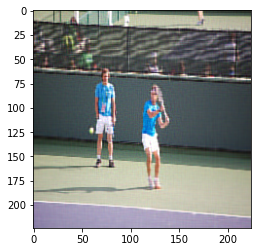

In [17]:
pred_img = dec(inputs)[0] + 0.5
# pred_img = dec(tf.random.normal(shape=(1, 128)))[0] * 255.0
# pred_img = tf.clip_by_value(pred_img, 0.0, 1.0)
# pred_img = tf.cast(pred_img, tf.uint8)
# print(tf.math.reduce_min(pred_img))
# print(pred_img)

plt.imshow(pred_img)

tf.Tensor(0.5, shape=(), dtype=float32)


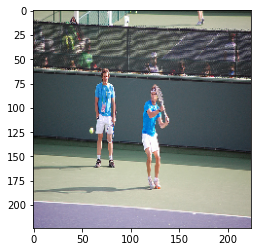

In [9]:
print(tf.math.reduce_max(ori_img))
plt.imshow(ori_img[0] + 0.5)

In [ ]:
MeanSquaredError()(ori_img, ori_img)